#### Variaveis para mudar:

chunk_size (tamanho da linha, dependendo se for vertical ou horizontal muda)
<br>
save_model_name (nome do modelo)
<br>
orientation (vertical ou horizontal)

In [1]:
from inference_utils import extract_level_representation, fix_level_format
from create_img import convert_kidicarus_to_png, convert_loderunner_to_png, convert_mario_to_png, convert_rainbowisland_to_png

In [2]:
from unsloth import FastLanguageModel
import torch
import os
from huggingface_hub import login
from unsloth.chat_templates import get_chat_template
from datasets import load_dataset
from unsloth.chat_templates import standardize_sharegpt
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported
from unsloth.chat_templates import train_on_responses_only

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/home/pressprexx/miniconda3/envs/unsloth/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!


In [4]:
save_model_name = "../models/rainbow_islands/Qwen-2.5-14b-horizontal-newline-1epoch-rainbow_island-teste1"

In [5]:
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

if True:
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = save_model_name, # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

==((====))==  Unsloth 2025.4.7: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 4060 Ti. Num GPUs = 1. Max memory: 15.697 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]
Unsloth 2025.4.7 patched 48 layers with 48 QKV layers, 48 O layers and 48 MLP layers.


In [6]:
messages = [
    {"role": "user", "content": "Create a level"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")


outputs = model.generate(input_ids = inputs, max_new_tokens = 1024, use_cache = True,
                         temperature = 1.8, min_p = 0.1)
response = tokenizer.batch_decode(outputs)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [7]:
print(response[0])

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
Create a level<|im_end|>
<|im_start|>assistant
................................
...BB..BBBBB....BBBBB..BB......
...BB..BBBBB....BBBBB..BB......
................................
................................
................................
................................
................................
................................
.......BBBBBBBBBBBBBBBBBBBB.....
.......BBBBBBBBBBBBBBBBBBBB.....
................................
................................
................................
BBBBBBB.........................
BBBBBBB.........................
................................
.............BBBBBB.............
.............BBBBBB.............
................................
................................
................................
................................
BBBBBBB....BBBBBBBBBBBBBBB..BBBB
BBBBBBB....BBBBBBBBBBBBBBB..BBBB
...............

In [8]:
level = extract_level_representation(response[0], model_type="qwen-2.5", orientation="horizontal", separator="\n")

In [9]:
print(level)

................................
...BB..BBBBB....BBBBB..BB......
...BB..BBBBB....BBBBB..BB......
................................
................................
................................
................................
................................
................................
.......BBBBBBBBBBBBBBBBBBBB.....
.......BBBBBBBBBBBBBBBBBBBB.....
................................
................................
................................
BBBBBBB.........................
BBBBBBB.........................
................................
.............BBBBBB.............
.............BBBBBB.............
................................
................................
................................
................................
BBBBBBB....BBBBBBBBBBBBBBB..BBBB
BBBBBBB....BBBBBBBBBBBBBBB..BBBB
................................
................................
................................
................................
................................
BBBBBBBBBBBB

In [10]:
fixed_level = fix_level_format(level, empty_space='.')
print(fixed_level)

................................
...BB..BBBBB....BBBBB..BB.......
...BB..BBBBB....BBBBB..BB.......
................................
................................
................................
................................
................................
................................
.......BBBBBBBBBBBBBBBBBBBB.....
.......BBBBBBBBBBBBBBBBBBBB.....
................................
................................
................................
BBBBBBB.........................
BBBBBBB.........................
................................
.............BBBBBB.............
.............BBBBBB.............
................................
................................
................................
................................
BBBBBBB....BBBBBBBBBBBBBBB..BBBB
BBBBBBB....BBBBBBBBBBBBBBB..BBBB
................................
................................
................................
................................
................................
BBBBBBBBBB

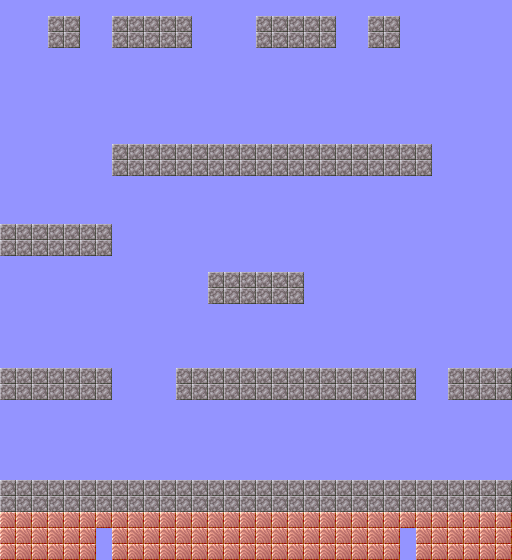

In [11]:
from IPython.display import display

# Call the function and extract the image
img, _, _ = convert_rainbowisland_to_png(fixed_level)

# Display the image in the notebook
display(img)

### Metrics

In [1]:
print(len("----####----####"))

16


In [ ]:
from metrics import SampledLevelEvaluator

def print_in_chunks(s, chunk_size=32):
    for i in range(0, len(s), chunk_size):
        print(s[i:i+chunk_size])

In [ ]:
# Settings (Mude dependendo do seu modelo)

orientation = 'horizontal'

horizontal_var = "str_horizontal_nosplit"
vertical_var = "str_vertical_nosplit"

data_path = '../level_json/rainbow_island/rainbow_island.json'
seperator = "\n"
level_to_evaluate = fixed_level

In [24]:
import json

sample_list = []
with open(data_path, 'r') as f:
    level_data = json.load(f)

print(level_data[-1]['window'])

for level in level_data:
    if orientation == 'horizontal':
        str_level = level[horizontal_var]
    else:
        str_level = level[vertical_var]
    sample_list.append(str_level)

print(sample_list[-1])

['....................BBBBBBBB..BB', '..BBBB....BBBBBBB...BBBBBBBB..BB', '..BBBB....BBBBBBB...BBBBBBBB..BB', '...............................B', '...............................B', '..............BBBBBBB..........B', 'BBBB..........BBBBBBB..........B', 'BBBB............................', '................................', '................................', '.....BBBBBBBBBBBBBB.............', '.....BBBBBBBBBBBBBB.............', '................................', '................................', '................................', '................................', '................................', 'BBBBB....BBBBBB.....BBBBBBBB....', 'BBBBB....BBBBBB.....BBBBBBBB....', 'BBBBB...........................', 'BBBB............................', 'BBBB............................', 'BBBB............................', 'BBBB..........BBBBBBBB..........', 'BBBB..........BBBBBBBB..........', '................................', '................................', '..........................

In [15]:
evaluation_level = level_to_evaluate.replace(seperator, '')
evaluator = SampledLevelEvaluator()

print(level_to_evaluate)

................................
...BB..BBBBB....BBBBB..BB.......
...BB..BBBBB....BBBBB..BB.......
................................
................................
................................
................................
................................
................................
.......BBBBBBBBBBBBBBBBBBBB.....
.......BBBBBBBBBBBBBBBBBBBB.....
................................
................................
................................
BBBBBBB.........................
BBBBBBB.........................
................................
.............BBBBBB.............
.............BBBBBB.............
................................
................................
................................
................................
BBBBBBB....BBBBBBBBBBBBBBB..BBBB
BBBBBBB....BBBBBBBBBBBBBBB..BBBB
................................
................................
................................
................................
................................
BBBBBBBBBB

In [16]:
# ATENÇÃO - Verifique que as fases do dataset e a fase gerada são do mesmo tamanho

print(len(sample_list[0]))
print(len(sample_list[1]))
print(len(evaluation_level))

1120
1120
1120


In [17]:
best_metrics = evaluator.evaluate_sample_on_dataset(sample_list, evaluation_level, metrics=["hamming_distance", "hamming_normalized", "chrF_score"])

Calculating metrics (sequential):   0%|          | 0/3847 [00:00<?, ?it/s]

Finding best metrics: 100%|██████████| 3847/3847 [00:00<00:00, 1511662.68it/s]


In [18]:
print(best_metrics)

{'hamming_distance': {'score': 158, 'level': '....................................................................................................................BB..............................BB...................................................................................................................................................................................................................................................................................BB..............................BB...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
print("\nBest metrics on dataset windows:")

for metric, data in best_metrics.items():
    print(f'\n\n{"*"*100}\n')
    print(f"\n{metric} => Score: {data['score']}, Level: ")
    print_in_chunks(data['level'], chunk_size=32)
    print(f'\n Original Level:')
    print(level_to_evaluate)


Best metrics on dataset windows:


****************************************************************************************************


hamming_distance => Score: 158, Level: 
................................
................................
................................
....................BB..........
....................BB..........
................................
................................
................................
................................
................................
................................
................................
................................
.........BB.....................
.........BB.....................
................................
................................
................................
................................
................................
................................
................................
................................
................................
.............................

### Gerar imagem comparativo

In [20]:
def chunk_string(s, chunk_size=50, separator="\n"):
    chunks = [s[i:i+chunk_size] for i in range(0, len(s), chunk_size)]
    return separator.join(chunks)

most_similar_for_image = best_metrics['hamming_distance']['level']
most_similar_for_image = chunk_string(most_similar_for_image, chunk_size=32)
print(most_similar_for_image)

................................
................................
................................
....................BB..........
....................BB..........
................................
................................
................................
................................
................................
................................
................................
................................
.........BB.....................
.........BB.....................
................................
................................
................................
................................
................................
................................
................................
................................
................................
................................
................................
................................
................................
................................
................................
BBBBBBBBBB

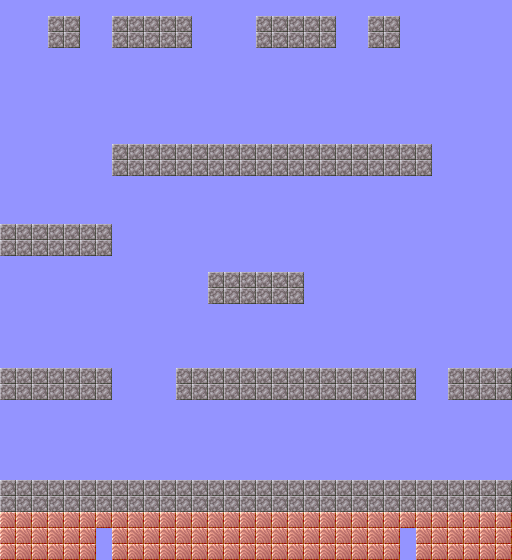

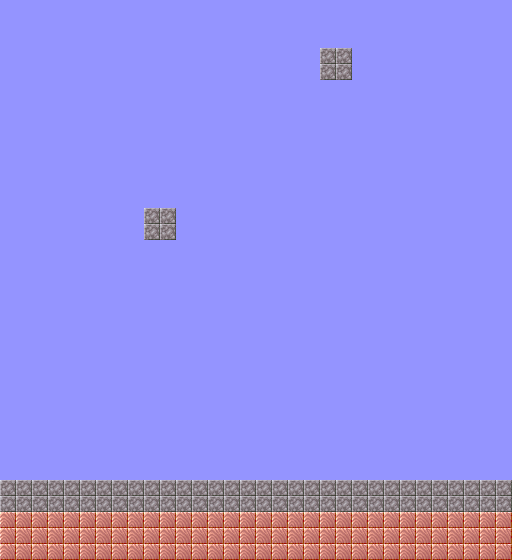

In [21]:
# img1, _, _ = convert_rainbowisland_to_png(fixed_level)
img2, _, _ = convert_rainbowisland_to_png(most_similar_for_image)

# Display the image in the notebook
display(img)
display(img2)